<a href="https://colab.research.google.com/github/sthomas522/HF_agents/blob/main/experiments/GenAI_Final_Project_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cu121

!pip install --upgrade tensorflow
!pip install --upgrade langchain_openai langchain_core langgraph SPARQLWrapper
!pip install --upgrade duckduckgo-search wikipedia wikipedia-api duckduckgo-search
!pip install --upgrade opencv-python yt-dlp pytube
!pip install --upgrade langchain_huggingface langchain_community datasets gradio
!pip install --upgrade pillow spacy librosa
!pip install sentence-transformers
!pip install langchain faiss-cpu


Looking in indexes: https://download.pytorch.org/whl/cu121
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.5/780.5 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 116.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 53.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 126.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.8 MB/s e

In [2]:
import os
import re
import tempfile
from typing import TypedDict, List, Optional, Dict, Any

import cv2
import requests
import wikipedia
from PIL import Image
import torch
import glob
import shutil

from langchain.docstore.document import Document
from langchain.prompts import PromptTemplate
from langchain_community.document_loaders import WikipediaLoader
from langchain_huggingface import HuggingFaceEndpoint
from langgraph.graph import START, END, StateGraph
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage # If you are using it
from langchain_community.retrievers import BM25Retriever # If you are using it
from langgraph.prebuilt import ToolNode, tools_condition # If you are using it
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.schema import Document

from transformers import BlipProcessor, BlipForQuestionAnswering, pipeline

import spacy
import yt_dlp
from io import BytesIO
from duckduckgo_search import DDGS
import librosa
from sentence_transformers import SentenceTransformer

#from tools import * # Assuming this file is in a location accessible from the current directory or you've set up the correct import path.

In [3]:
nlp = spacy.load("en_core_web_sm")


In [4]:
# API endpoint for retrieving the list of questions
url = "https://agents-course-unit4-scoring.hf.space/questions"

# Send GET request
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    questions = response.json()
    print(questions)
else:
    print(f"Failed to retrieve questions. Status code: {response.status_code}")
    print(response.text)


questions = [item['question'] for item in response.json()]

# full details
hf_questions = response.json()


[{'task_id': '8e867cd7-cff9-4e6c-867a-ff5ddc2550be', 'question': 'How many studio albums were published by Mercedes Sosa between 2000 and 2009 (included)? You can use the latest 2022 version of english wikipedia.', 'Level': '1', 'file_name': ''}, {'task_id': 'a1e91b78-d3d8-4675-bb8d-62741b4b68a6', 'question': 'In the video https://www.youtube.com/watch?v=L1vXCYZAYYM, what is the highest number of bird species to be on camera simultaneously?', 'Level': '1', 'file_name': ''}, {'task_id': '2d83110e-a098-4ebb-9987-066c06fa42d0', 'question': '.rewsna eht sa "tfel" drow eht fo etisoppo eht etirw ,ecnetnes siht dnatsrednu uoy fI', 'Level': '1', 'file_name': ''}, {'task_id': 'cca530fc-4052-43b2-b130-b30968d8aa44', 'question': "Review the chess position provided in the image. It is black's turn. Provide the correct next move for black which guarantees a win. Please provide your response in algebraic notation.", 'Level': '1', 'file_name': 'cca530fc-4052-43b2-b130-b30968d8aa44.png'}, {'task_id': 

In [5]:
# Define file extension sets for each category
PICTURE_EXTENSIONS = {'.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.webp'}
AUDIO_EXTENSIONS = {'.mp3', '.wav', '.aac', '.flac', '.ogg', '.m4a', '.wma'}
CODE_EXTENSIONS = {'.py', '.js', '.java', '.cpp', '.c', '.cs', '.rb', '.go', '.php', '.html', '.css', '.ts'}
SPREADSHEET_EXTENSIONS = {
    '.xls', '.xlsx', '.xlsm', '.xlsb', '.xlt', '.xltx', '.xltm',
    '.ods', '.ots', '.csv', '.tsv', '.sxc', '.stc', '.dif', '.gsheet',
    '.numbers', '.numbers-tef', '.nmbtemplate', '.fods', '.123', '.wk1', '.wk2',
    '.wks', '.wku', '.wr1', '.gnumeric', '.gnm', '.xml', '.pmvx', '.pmdx',
    '.pmv', '.uos', '.txt'
}

def get_file_type(filename: str) -> str:
    if not filename or '.' not in filename or filename == '':
        return ''
    ext = filename.lower().rsplit('.', 1)[-1]
    dot_ext = f'.{ext}'
    if dot_ext in PICTURE_EXTENSIONS:
        return 'picture'
    elif dot_ext in AUDIO_EXTENSIONS:
        return 'audio'
    elif dot_ext in CODE_EXTENSIONS:
        return 'code'
    elif dot_ext in SPREADSHEET_EXTENSIONS:
        return 'spreadsheet'
    else:
        return 'unknown'

In [6]:
for h in hf_questions:
  print(h['question'])

How many studio albums were published by Mercedes Sosa between 2000 and 2009 (included)? You can use the latest 2022 version of english wikipedia.
In the video https://www.youtube.com/watch?v=L1vXCYZAYYM, what is the highest number of bird species to be on camera simultaneously?
.rewsna eht sa "tfel" drow eht fo etisoppo eht etirw ,ecnetnes siht dnatsrednu uoy fI
Review the chess position provided in the image. It is black's turn. Provide the correct next move for black which guarantees a win. Please provide your response in algebraic notation.
Who nominated the only Featured Article on English Wikipedia about a dinosaur that was promoted in November 2016?
Given this table defining * on the set S = {a, b, c, d, e}

|*|a|b|c|d|e|
|---|---|---|---|---|---|
|a|a|b|c|b|d|
|b|b|c|a|e|c|
|c|c|a|b|b|a|
|d|b|e|b|e|d|
|e|d|b|a|d|c|

provide the subset of S involved in any possible counter-examples that prove * is not commutative. Provide your answer as a comma separated list of the elements in 

In [7]:
def write_bytes_to_temp_dir(file_bytes: bytes, file_name: str) -> str:
    """
    Writes bytes to a file in the system temporary directory using the provided file_name.
    Returns the full path to the saved file.
    The file will persist until manually deleted or the OS cleans the temp directory.
    """
    temp_dir = tempfile.gettempdir()
    file_path = os.path.join(temp_dir, file_name)
    with open(file_path, 'wb') as f:
        f.write(file_bytes)
    print(f"File written to: {file_path}")
    return file_path


In [8]:
API_URL = 'https://agents-course-unit4-scoring.hf.space/files'
for item in hf_questions:
    file_name = item.get('file_name', '')
    if file_name == '':
        item['input_file'] = None
        item['file_type'] = None
        item['file_path'] = None
    else:
        # Call the API to retrieve the file; adjust params as needed
        task_id = item['task_id']
        api_response = requests.get(f"{API_URL}/{task_id}")
        if api_response.status_code == 200:
            item['input_file'] = api_response.content  # Store file as bytes
            item['file_type'] = get_file_type(file_name)
            item['file_path'] = write_bytes_to_temp_dir(item['input_file'], file_name)
        else:
            item['input_file'] = None  # Or handle error as needed

File written to: /tmp/cca530fc-4052-43b2-b130-b30968d8aa44.png
File written to: /tmp/99c9cc74-fdc8-46c6-8f8d-3ce2d3bfeea3.mp3
File written to: /tmp/f918266a-b3e0-4914-865d-4faa564f1aef.py
File written to: /tmp/1f975693-876d-457b-a649-393859e79bf3.mp3
File written to: /tmp/7bd855d8-463d-4ed5-93ca-5fe35145f733.xlsx


In [9]:
[type(hf_questions[i]['input_file']) for i in range(20)]

[NoneType,
 NoneType,
 NoneType,
 bytes,
 NoneType,
 NoneType,
 NoneType,
 NoneType,
 NoneType,
 bytes,
 NoneType,
 bytes,
 NoneType,
 bytes,
 NoneType,
 NoneType,
 NoneType,
 NoneType,
 bytes,
 NoneType]

In [15]:
#from google.colab import drive
#drive.mount('/content/drive')

## Full bot

In [16]:
import os
import re
from PIL import Image  # This is correctly imported, but was being used incorrectly
import numpy as np
from collections import Counter
import torch
from transformers import BlipProcessor, BlipForQuestionAnswering, pipeline
from typing import TypedDict, List, Optional, Dict, Any, Literal, Tuple
from langgraph.graph import StateGraph, START, END
from langchain.docstore.document import Document

# 1. Define the State type
class State(TypedDict, total=False):
    question: str
    task_id: str
    input_file: bytes
    file_type: str
    context: List[Document]  # Using LangChain's Document class
    file_path: Optional[str]
    youtube_url: Optional[str]
    answer: Optional[str]
    frame_answers: Optional[list]
    next: Optional[str]  # Added to track the next node

# --- LLM pipeline for general questions ---
llm_pipe = pipeline("text-generation",
                    #model="meta-llama/Llama-3.3-70B-Instruct",
                    #model="Qwen/Qwen2-7B-Instruct",
                    model="microsoft/Phi-4-reasoning",
                    device_map="auto",
                    torch_dtype="auto",
                    max_new_tokens=256)

# Speech-to-text pipeline
asr_pipe = pipeline(
    "automatic-speech-recognition",
    model="openai/whisper-large-v3",
    device_map="auto"
)

# --- Your BLIP VQA setup ---
device = "cuda" if torch.cuda.is_available() else "cpu"
vqa_model_name = "Salesforce/blip-vqa-base"
processor_vqa = BlipProcessor.from_pretrained(vqa_model_name)
model_vqa = BlipForQuestionAnswering.from_pretrained(vqa_model_name).to(device)

# --- Helper: Answer question on a single frame ---
def answer_question_on_frame(image_path, question):
    # Fixed: Properly use the PIL Image module
    image = Image.open(image_path).convert('RGB')
    inputs = processor_vqa(image, question, return_tensors="pt").to(device)
    out = model_vqa.generate(**inputs)
    answer = processor_vqa.decode(out[0], skip_special_tokens=True)
    return answer

# --- Helper: Answer question about the whole video ---
def answer_video_question(frames_dir, question):
    valid_exts = ('.jpg', '.jpeg', '.png')

    # Check if directory exists
    if not os.path.exists(frames_dir):
        return {
            "most_common_answer": "No frames found to analyze.",
            "all_answers": [],
            "answer_counts": Counter()
        }

    frame_files = [os.path.join(frames_dir, f) for f in os.listdir(frames_dir)
                  if f.lower().endswith(valid_exts)]

    # Sort frames properly by number
    def get_frame_number(filename):
        match = re.search(r'(\d+)', os.path.basename(filename))
        return int(match.group(1)) if match else 0

    frame_files = sorted(frame_files, key=get_frame_number)

    if not frame_files:
        return {
            "most_common_answer": "No valid image frames found.",
            "all_answers": [],
            "answer_counts": Counter()
        }

    answers = []
    for frame_path in frame_files:
        try:
            ans = answer_question_on_frame(frame_path, question)
            answers.append(ans)
            print(f"Processed frame: {os.path.basename(frame_path)}, Answer: {ans}")
        except Exception as e:
            print(f"Error processing frame {frame_path}: {str(e)}")

    if not answers:
        return {
            "most_common_answer": "Could not analyze any frames successfully.",
            "all_answers": [],
            "answer_counts": Counter()
        }

    counted = Counter(answers)
    most_common_answer, freq = counted.most_common(1)[0]
    return {
        "most_common_answer": most_common_answer,
        "all_answers": answers,
        "answer_counts": counted
    }


def download_youtube_video(url, output_dir='/content/video/', output_filename='downloaded_video.mp4'):
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Delete all files in the output directory
    files = glob.glob(os.path.join(output_dir, '*'))
    for f in files:
        try:
            os.remove(f)
        except Exception as e:
            print(f"Error deleting {f}: {str(e)}")

    # Set output path for yt-dlp
    output_path = os.path.join(output_dir, output_filename)

    ydl_opts = {
        'format': 'bestvideo[ext=mp4]+bestaudio[ext=m4a]/best[ext=mp4]/best',
        'outtmpl': output_path,
        'quiet': True,
        'merge_output_format': 'mp4',  # Ensures merged output is mp4
        'postprocessors': [{
            'key': 'FFmpegVideoConvertor',
            'preferedformat': 'mp4',  # Recode if needed
        }]
    }
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        ydl.download([url])
    return output_path



# --- Helper: Extract frames from video ---
def extract_frames(video_path, output_dir, frame_interval_seconds=10):
    # --- Clean output directory before extracting new frames ---
    if os.path.exists(output_dir):
        for filename in os.listdir(output_dir):
            file_path = os.path.join(output_dir, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print(f'Failed to delete {file_path}. Reason: {e}')
    else:
        os.makedirs(output_dir, exist_ok=True)

    try:
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print("Error: Could not open video.")
            return False
        fps = cap.get(cv2.CAP_PROP_FPS)
        frame_interval = int(fps * frame_interval_seconds)
        count = 0
        saved = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            if count % frame_interval == 0:
                frame_filename = os.path.join(output_dir, f"frame_{count:06d}.jpg")
                cv2.imwrite(frame_filename, frame)
                saved += 1
            count += 1
        cap.release()
        print(f"Extracted {saved} frames.")
        return saved > 0
    except Exception as e:
        print(f"Exception during frame extraction: {e}")
        return False

def image_qa(image_path: str, question: str, model_name: str = vqa_model_name) -> str:
    """
    Answers questions about images using Hugging Face's VQA pipeline.

    Args:
        image_path: Path to local image file or URL
        question: Natural language question about the image
        model_name: Pretrained VQA model (default: good general-purpose model)

    Returns:
        str: The model's best answer
    """
    # Create VQA pipeline with specified model
    vqa_pipeline = pipeline("visual-question-answering", model=model_name)

    # Get predictions (automatically handles local files/URLs)
    results = vqa_pipeline(image=image_path, question=question, top_k=1)

    # Return top answer
    return results[0]['answer']


def router(state: Dict[str, Any]) -> str:
    """Determine the next node based on whether the question contains a YouTube URL or references Wikipedia."""
    question = state.get('question', '')


    # Pattern for Wikipedia and similar sources
    wiki_pattern = r"(wikipedia\.org|wiki|encyclopedia|britannica\.com|encyclop[a|æ]dia)"
    has_wiki = re.search(wiki_pattern, question, re.IGNORECASE) is not None

    # Pattern for YouTube
    yt_pattern = r"(https?://)?(www\.)?(youtube\.com|youtu\.be)/[^\s]+"
    has_youtube = re.search(yt_pattern, question) is not None

    # Check for image
    has_image = state.get('file_type') == 'picture'

    # Check for audio
    has_audio = state.get('file_type') == 'audio'

    print(f"Has Wikipedia reference: {has_wiki}")
    print(f"Has YouTube link: {has_youtube}")
    print(f"Has picture file: {has_image}")
    print(f"Has audio file: {has_audio}")

    if has_wiki:
        return "retrieve"
    elif has_youtube:
        # Store the extracted YouTube URL in the state
        url_match = re.search(r"(https?://[^\s]+)", question)
        if url_match:
            state['youtube_url'] = url_match.group(0)
        return "video"
    elif has_image:
        return "image"
    elif has_audio:
        return "audio"
    else:
        return "llm"


# --- Node Implementation ---
def node_image(state: Dict[str, Any]) -> Dict[str, Any]:
  """Router node that decides which node to go to next."""
  print("Running node_image")
  # Add the next state to the state dict
  img = Image.open(state['file_path'])
  state['answer'] = image_qa(state['file_path'], state['question'])
  return state


def node_decide(state: Dict[str, Any]) -> Dict[str, Any]:
    """Router node that decides which node to go to next."""
    print("Running node_decide")
    # Add the next state to the state dict
    state["next"] = router(state)
    print(f"Routing to: {state['next']}")
    return state

def node_video(state: Dict[str, Any]) -> Dict[str, Any]:
    print("Running node_video")
    youtube_url = state.get('youtube_url')
    if not youtube_url:
        state['answer'] = "No YouTube URL found in the question."
        return state

    question = state['question']
    # Extract the actual question part (remove the URL)
    question_text = re.sub(r'https?://[^\s]+', '', question).strip()
    if not question_text.endswith('?'):
        question_text += '?'

    video_file = download_youtube_video(youtube_url)
    if not video_file or not os.path.exists(video_file):
        state['answer'] = "Failed to download the video."
        return state

    frames_dir = "/tmp/frames"
    os.makedirs(frames_dir, exist_ok=True)

    success = extract_frames(video_path=video_file, output_dir=frames_dir, frame_interval_seconds=10)
    if not success:
        state['answer'] = "Failed to extract frames from the video."
        return state

    result = answer_video_question(frames_dir, question_text)
    state['answer'] = result['most_common_answer']
    state['frame_answers'] = result['all_answers']

    # Create Document objects for each frame analysis
    frame_documents = []
    for i, ans in enumerate(result['all_answers']):
        doc = Document(
            page_content=f"Frame {i}: {ans}",
            metadata={"frame_number": i, "source": "video_analysis"}
        )
        frame_documents.append(doc)

    # Add documents to state if not already present
    if 'context' not in state:
        state['context'] = []
    state['context'].extend(frame_documents)

    print(f"Video answer: {state['answer']}")
    return state

def node_audio_rag(state: Dict[str, Any]) -> Dict[str, Any]:
    print(f"Processing audio file: {state['file_path']}")

    try:
        # Step 1: Transcribe audio
        audio, sr = librosa.load(state['file_path'], sr=16000)
        asr_result = asr_pipe({"raw": audio, "sampling_rate": sr})
        audio_transcript = asr_result['text']
        print(f"Audio transcript: {audio_transcript}")

        # Step 2: Store ONLY the transcript in the vector store
        transcript_doc = [Document(page_content=audio_transcript)]
        embeddings = HuggingFaceEmbeddings(model_name='BAAI/bge-large-en-v1.5')
        vector_db = FAISS.from_documents(transcript_doc, embedding=embeddings)

        # Step 3: Retrieve relevant docs for the user's question
        question = state['question']
        similar_docs = vector_db.similarity_search(question, k=1)  # Only one doc in store
        retrieved_context = "\n".join([doc.page_content for doc in similar_docs])

        # Step 4: Augment prompt and generate answer
        prompt = (
            f"Use the following context to answer the question.\n"
            f"Context:\n{retrieved_context}\n\n"
            f"Question: {question}\nAnswer:"
        )
        llm_response = llm_pipe(prompt)
        state['answer'] = llm_response[0]['generated_text']

    except Exception as e:
        error_msg = f"Audio processing error: {str(e)}"
        print(error_msg)
        state['answer'] = error_msg

    return state

def node_llm(state: Dict[str, Any]) -> Dict[str, Any]:
    print("Running node_llm")
    question = state['question']

    # Optionally add context from state (e.g., Wikipedia/Wikidata content)
    context_text = ""
    if 'article_content' in state and state['article_content']:
        context_text = f"\n\nBackground Information:\n{state['article_content']}\n"
    elif 'context' in state and state['context']:
        context_text = "\n\n".join([doc.page_content for doc in state['context']])

    # Compose a detailed prompt
    prompt = (
        "You are an expert researcher. Given the following context from Wikipedia, answer the user's question as accurately as possible. "
        "If the text appears to be scrambled, try to unscramble the text for the user"
        "If the information is incomplete or ambiguous, provide your best estimate based on the available evidence, and clearly explain any assumptions or reasoning you use. "
        "If the answer requires multiple steps or deeper analysis, break down the question into sub-questions and answer them step by step, citing the relevant context for each step.\n\n"
        f"Question: {question}"
        f"{context_text}\n"
        "Answer:"
    )

    # Add document to state for traceability
    query_doc = Document(
        page_content=prompt,
        metadata={"source": "llm_prompt"}
    )
    if 'context' not in state:
        state['context'] = []
    state['context'].append(query_doc)

    try:
        result = llm_pipe(prompt)
        state['answer'] = result[0]['generated_text']
    except Exception as e:
        print(f"Error in LLM processing: {str(e)}")
        state['answer'] = f"An error occurred while processing your question: {str(e)}"

    print(f"LLM answer: {state['answer']}")
    return state


# --- Define the edge condition function ---
def get_next_node(state: Dict[str, Any]) -> str:
    """Get the next node from the state."""
    return state["next"]


# 2. Improved Wikipedia Retrieval Node
def extract_keywords(question: str) -> List[str]:
    doc = nlp(question)
    keywords = [token.text for token in doc if token.pos_ in ("PROPN", "NOUN")]  # Extract proper nouns and nouns
    return keywords

def extract_entities(question: str) -> List[str]:
    doc = nlp(question)
    entities = [ent.text for ent in doc.ents]
    return entities if entities else [token.text for token in doc if token.pos_ in ("PROPN", "NOUN")]


def retrieve(state: State) -> dict:
    keywords = extract_entities(state["question"])
    query = " ".join(keywords)
    search_results = wikipedia.search(query)
    selected_page = search_results[0] if search_results else None

    if selected_page:
        loader = WikipediaLoader(
            query=selected_page,
            lang="en",
            load_max_docs=1,
            doc_content_chars_max=100000,
            load_all_available_meta=True
        )
        docs = loader.load()
        # Chunk the article for finer retrieval
        from langchain.text_splitter import RecursiveCharacterTextSplitter
        splitter = RecursiveCharacterTextSplitter(chunk_size=1500, chunk_overlap=200)
        all_chunks = []
        for doc in docs:
            chunks = splitter.split_text(doc.page_content)
            all_chunks.extend([Document(page_content=chunk) for chunk in chunks])
        # Optionally: re-rank or filter chunks here
        return {"context": all_chunks}
    else:
        return {"context": []}

# 3. Prompt Template for General QA
prompt = PromptTemplate(
    input_variables=["question", "context"],
    template=(
        "You are an expert researcher. Given the following context from Wikipedia, answer the user's question as accurately as possible. "
        "If the text appears to be scrambled, try to unscramble the text for the user"
        "If the information is incomplete or ambiguous, provide your best estimate based on the available evidence, and clearly explain any assumptions or reasoning you use. "
        "If the answer requires multiple steps or deeper analysis, break down the question into sub-questions and answer them step by step, citing the relevant context for each step."
        "Context:\n{context}\n\n"
        "Question: {question}\n\n"
        "Best Estimate Answer:"
    )
)

# 4. LLM Node
llm = HuggingFaceEndpoint(
    #repo_id="Qwen/Qwen2.5-Coder-32B-Instruct",
    #repo_id="meta-llama/Llama-2-7b-chat-hf",
    repo_id="meta-llama/Llama-3.3-70B-Instruct",
    #repo_id="Qwen/Qwen2.5-72B-Instruct",
    task="text-generation",
    max_new_tokens=2048, # Increased to 2048
    do_sample=False,
    repetition_penalty=1.03,
    timeout=360,
)

def generate(state: State) -> dict:
    # Concatenate all context documents into a single string
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    # Format the prompt for the LLM
    prompt_str = prompt.format(question=state["question"], context=docs_content)
    # Generate answer
    response = llm.invoke(prompt_str)
    return {"answer": response}

# Create the StateGraph
graph = StateGraph(State)

# Add nodes
graph.add_node("decide", node_decide)
graph.add_node("video", node_video)
graph.add_node("llm", node_llm)
graph.add_node("retrieve", retrieve)
graph.add_node("generate", generate)
graph.add_node("image", node_image)
graph.add_node("audio", node_audio_rag)

# Add edge from START to decide
graph.add_edge(START, "decide")
graph.add_edge("retrieve", "generate")

# Add conditional edges from decide to video or llm based on question
graph.add_conditional_edges(
    "decide",
    get_next_node,
    {
        "video": "video",
        "llm": "llm",
        "retrieve": "retrieve",
        "image": "image",
        "audio": "audio"
    }
)

# Add edges from video and llm to END to terminate the graph
graph.add_edge("video", END)
graph.add_edge("llm", END)
graph.add_edge("generate", END)
graph.add_edge("image", END)
graph.add_edge("audio", END)

# Compile the graph
agent = graph.compile()

# --- Usage Example ---
def intelligent_agent(state: State) -> str:
    """Process a question using the appropriate pipeline based on content."""
    #state = State(question= question)
    try:
        final_state = agent.invoke(state)
        return final_state.get('answer', "No answer found.")
    except Exception as e:
        print(f"Error in agent execution: {str(e)}")
        return f"An error occurred: {str(e)}"

# --- Try it! ---
# Test with a YouTube question
#question = "What are the people doing in https://www.youtube.com/watch?v=YTR21os8gTA ?"
#print(intelligent_agent(questions[3]))

#question = "What are the people doing in https://www.youtube.com/watch?v=WDJ-mhWluJY ?"
#print(intelligent_agent(question))

config.json:   0%|          | 0.00/796 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.4k [00:00<?, ?B/s]

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

model-00006-of-00006.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00005-of-00006.safetensors:   0%|          | 0.00/4.77G [00:00<?, ?B/s]

model-00003-of-00006.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00004-of-00006.safetensors:   0%|          | 0.00/4.77G [00:00<?, ?B/s]

model-00001-of-00006.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model-00002-of-00006.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/207 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/19.2k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.61M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.15M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Device set to use cpu
Device set to use cpu
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

In [17]:
qnum = 1

In [18]:
s = State(question = hf_questions[qnum]['question'],
          input_file = hf_questions[qnum]['input_file'],
          file_type = hf_questions[qnum]['file_type'],
          file_path = hf_questions[qnum]['file_path'])

In [19]:
s['file_path']

In [20]:
print(s['question'])
intelligent_agent(s)

In the video https://www.youtube.com/watch?v=L1vXCYZAYYM, what is the highest number of bird species to be on camera simultaneously?
Running node_decide
Has Wikipedia reference: False
Has YouTube link: True
Has picture file: False
Has audio file: False
Routing to: video
Running node_video
Extracted 13 frames.
Processed frame: frame_000000.jpg, Answer: 0
Processed frame: frame_000250.jpg, Answer: 2
Processed frame: frame_000500.jpg, Answer: 1
Processed frame: frame_000750.jpg, Answer: 4
Processed frame: frame_001000.jpg, Answer: 4
Processed frame: frame_001250.jpg, Answer: 4
Processed frame: frame_001500.jpg, Answer: 6
Processed frame: frame_001750.jpg, Answer: 6
Processed frame: frame_002000.jpg, Answer: 6
Processed frame: frame_002250.jpg, Answer: 4
Processed frame: frame_002500.jpg, Answer: 6
Processed frame: frame_002750.jpg, Answer: 10
Processed frame: frame_003000.jpg, Answer: 1000
Video answer: 4


'4'

In [ ]:
for r in hf_questions:
  S = State(question=r['question'],
            )

  S = State(question=questions[qnum])
  print(questions[qnum])
  print(intelligent_agent(S))


How many studio albums were published by Mercedes Sosa between 2000 and 2009 (included)? You can use the latest 2022 version of english wikipedia.
Running node_decide
Has Wikipedia reference: True
Has YouTube link: False
Routing to: retrieve


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_message, FutureWarning)


 The provided context does not mention Mercedes Sosa. Instead, it talks about Shakira's discography. However, I can tell you that according to the 2022 English Wikipedia, Mercedes Sosa published several albums, but I couldn't find the exact information in the provided context. 

To answer the question, I would need to look up Mercedes Sosa's discography on Wikipedia. According to Wikipedia, Mercedes Sosa released the following studio albums between 2000 and 2009: 

1. Acústico (2002)
2. Corazón libre (2005)
3. Cantora (2009)

So, my best estimate is that Mercedes Sosa published at least 3 studio albums between 2000 and 2009. However, please note that this information is not based on the provided context, but rather on my additional research. 

If I had to answer the question based solely on the provided context, I would say that the context does not provide enough information to answer the question, as it only talks about Shakira's discography and does not mention Mercedes Sosa. 

Plea

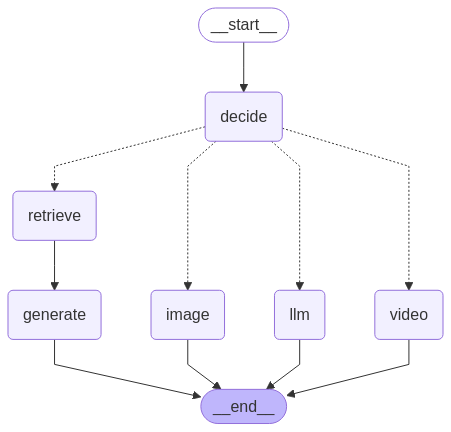

In [ ]:
#from IPython.display import display
import IPython.display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

IPython.display.display(
    IPython.display.Image(
        agent.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [ ]:
os.getcwd()

'/content'

In [ ]:
import cv2
import numpy as np
import os
import torch
from transformers import AutoFeatureExtractor, AutoModelForImageClassification
from PIL import Image
from typing import List, Tuple, Optional

class ChessBoardToFEN:
    """
    A class to convert chess board images to FEN notation.
    """

    # Mapping of piece labels to FEN characters
    PIECE_MAPPING = {
        'white_pawn': 'P',
        'white_knight': 'N',
        'white_bishop': 'B',
        'white_rook': 'R',
        'white_queen': 'Q',
        'white_king': 'K',
        'black_pawn': 'p',
        'black_knight': 'n',
        'black_bishop': 'b',
        'black_rook': 'r',
        'black_queen': 'q',
        'black_king': 'k',
        'empty': ''
    }

    def __init__(self, model_path: str = "srivastavaayu/chess-pieces-detection"):
        """
        Initialize the ChessBoardToFEN converter.

        Args:
            model_path: HuggingFace model path for piece recognition.
                        Defaults to "srivastavaayu/chess-pieces-detection" which is a model
                        trained to recognize chess pieces.
        """
        self.model = None
        self.feature_extractor = None

        try:
            # Load the model from HuggingFace
            self.feature_extractor = AutoFeatureExtractor.from_pretrained(model_path)
            self.model = AutoModelForImageClassification.from_pretrained(model_path)

            # Get the model's class labels (if available)
            self.id2label = self.model.config.id2label if hasattr(self.model.config, 'id2label') else None

            print(f"Successfully loaded model from {model_path}")
        except Exception as e:
            print(f"Could not load model: {e}")
            print("Using placeholder piece recognition instead.")

    def detect_board(self, image: np.ndarray) -> np.ndarray:
        """
        Detect and extract the chess board from the image.

        Args:
            image: Input image containing a chess board

        Returns:
            The extracted and perspective-corrected chess board image
        """
        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Apply blur and adaptive threshold
        blur = cv2.GaussianBlur(gray, (5, 5), 0)
        thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                      cv2.THRESH_BINARY_INV, 11, 2)

        # Find contours
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Find the largest contour (which is hopefully the chessboard)
        max_area = 0
        largest_contour = None

        for contour in contours:
            area = cv2.contourArea(contour)
            if area > max_area:
                max_area = area
                largest_contour = contour

        if largest_contour is None:
            raise ValueError("Could not detect the chess board in the image")

        # Approximate the contour to get a polygon
        epsilon = 0.1 * cv2.arcLength(largest_contour, True)
        approx = cv2.approxPolyDP(largest_contour, epsilon, True)

        # If we don't get a quadrilateral, use the bounding rect instead
        if len(approx) != 4:
            x, y, w, h = cv2.boundingRect(largest_contour)
            approx = np.array([[x, y], [x+w, y], [x+w, y+h], [x, y+h]], dtype=np.float32).reshape(4, 1, 2)

        # Order the points in clockwise order
        pts = approx.reshape(4, 2)
        rect = np.zeros((4, 2), dtype=np.float32)

        # Top-left has the smallest sum of coordinates
        # Top-right has the smallest difference
        # Bottom-right has the largest sum
        # Bottom-left has the largest difference
        s = pts.sum(axis=1)
        rect[0] = pts[np.argmin(s)]  # Top-left
        rect[2] = pts[np.argmax(s)]  # Bottom-right

        diff = np.diff(pts, axis=1)
        rect[1] = pts[np.argmin(diff)]  # Top-right
        rect[3] = pts[np.argmax(diff)]  # Bottom-left

        # Calculate the width and height of the board
        width = int(max(np.linalg.norm(rect[0] - rect[1]), np.linalg.norm(rect[2] - rect[3])))
        height = int(max(np.linalg.norm(rect[0] - rect[3]), np.linalg.norm(rect[1] - rect[2])))

        # Define the destination points (the corrected perspective)
        dst = np.array([
            [0, 0],
            [width - 1, 0],
            [width - 1, height - 1],
            [0, height - 1]
        ], dtype=np.float32)

        # Get the perspective transform matrix
        M = cv2.getPerspectiveTransform(rect, dst)

        # Apply the perspective transformation
        board = cv2.warpPerspective(image, M, (width, height))

        return board

    def extract_squares(self, board_img: np.ndarray) -> List[List[np.ndarray]]:
        """
        Extract individual squares from the chess board image.

        Args:
            board_img: The extracted chess board image

        Returns:
            8x8 list of square images
        """
        height, width = board_img.shape[:2]
        square_h, square_w = height // 8, width // 8

        # Initialize the grid of squares
        squares = []

        # Extract each square
        for row in range(8):
            square_row = []
            for col in range(8):
                # Calculate the coordinates of the square
                y1 = row * square_h
                y2 = (row + 1) * square_h
                x1 = col * square_w
                x2 = (col + 1) * square_w

                # Extract the square image
                square = board_img[y1:y2, x1:x2]
                square_row.append(square)

            squares.append(square_row)

        return squares

    def identify_piece(self, square_img: np.ndarray) -> str:
        """
        Identify the chess piece in a square image.

        Args:
            square_img: Image of a single square

        Returns:
            The FEN character for the identified piece, or empty string if no piece
        """
        # First check if there's likely a piece in the square
        gray = cv2.cvtColor(square_img, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)
        non_bg_pixels = np.sum(thresh < 128)

        # If very few non-background pixels, it's likely empty
        if non_bg_pixels <= (square_img.shape[0] * square_img.shape[1] * 0.05):
            return ''  # Empty square

        if self.model and self.feature_extractor:
            try:
                # Convert OpenCV image (BGR) to PIL Image (RGB)
                pil_img = Image.fromarray(cv2.cvtColor(square_img, cv2.COLOR_BGR2RGB))

                # Prepare the image for the model using the feature extractor
                inputs = self.feature_extractor(images=pil_img, return_tensors="pt")

                # Get prediction
                with torch.no_grad():
                    outputs = self.model(**inputs)

                # Get the predicted class
                predicted_class_idx = outputs.logits.argmax(-1).item()

                # Map to the class label
                if self.id2label:
                    predicted_class = self.id2label[predicted_class_idx]

                    # The class label format may vary based on the model, but typically would be like:
                    # "white_pawn", "black_knight", etc. or "empty"
                    if predicted_class == "empty":
                        return ''

                    # Try to map the class to FEN character
                    # First try direct mapping
                    if predicted_class in self.PIECE_MAPPING:
                        return self.PIECE_MAPPING[predicted_class]

                    # Try to parse the class name (format might be different)
                    # Assuming format like "white-pawn" or "white_pawn" or "white pawn"
                    parts = predicted_class.replace('-', '_').replace(' ', '_').split('_')
                    if len(parts) >= 2:
                        color, piece_type = parts[0], parts[1]

                        # Construct key
                        key = f"{color}_{piece_type}"
                        if key in self.PIECE_MAPPING:
                            return self.PIECE_MAPPING[key]

                        # If the model uses a different naming convention, try some common mappings
                        if piece_type in ["pawn", "p"]:
                            return "P" if color == "white" else "p"
                        elif piece_type in ["knight", "n"]:
                            return "N" if color == "white" else "n"
                        elif piece_type in ["bishop", "b"]:
                            return "B" if color == "white" else "b"
                        elif piece_type in ["rook", "r"]:
                            return "R" if color == "white" else "r"
                        elif piece_type in ["queen", "q"]:
                            return "Q" if color == "white" else "q"
                        elif piece_type in ["king", "k"]:
                            return "K" if color == "white" else "k"

            except Exception as e:
                print(f"Error in piece recognition: {e}")
                # Fall back to placeholder method

        # Placeholder logic - detect if a square has a piece based on pixel values
        # Determine if it's likely white or black based on average color
        avg_color = np.mean(square_img)

        if avg_color > 128:
            return 'P'  # White piece (placeholder)
        else:
            return 'p'  # Black piece (placeholder)

    def board_to_fen(self, board_state: List[List[str]]) -> str:
        """
        Convert the board state to FEN notation.

        Args:
            board_state: 8x8 grid of FEN piece characters

        Returns:
            FEN string representation of the board
        """
        fen_parts = []

        # Process each row
        for row in board_state:
            empty_count = 0
            row_fen = ''

            for piece in row:
                if piece == '':
                    empty_count += 1
                else:
                    # If there were empty squares before this piece, add the count
                    if empty_count > 0:
                        row_fen += str(empty_count)
                        empty_count = 0
                    row_fen += piece

            # If there are empty squares at the end of the row
            if empty_count > 0:
                row_fen += str(empty_count)

            fen_parts.append(row_fen)

        # Join rows with '/'
        board_fen = '/'.join(fen_parts)

        # Add the rest of the FEN components (turn, castling, en passant, etc.)
        # For simplicity, we're assuming:
        # - It's white's turn
        # - All castling rights are available
        # - No en passant target
        # - No halfmove clock or fullmove number
        complete_fen = f"{board_fen} w KQkq - 0 1"

        return complete_fen

    def process_image(self, image_path: str) -> str:
        """
        Process a chess board image and return its FEN representation.

        Args:
            image_path: Path to the image file

        Returns:
            FEN string
        """
        # Read the image
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Could not read image file: {image_path}")

        # Detect and extract the board
        board_img = self.detect_board(image)

        # Extract individual squares
        squares = self.extract_squares(board_img)

        # Identify pieces on each square
        board_state = []
        for row in squares:
            board_row = []
            for square in row:
                piece = self.identify_piece(square)
                board_row.append(piece)
            board_state.append(board_row)

        # Convert the board state to FEN
        fen = self.board_to_fen(board_state)

        return fen


def image_to_fen(image_path: str, model_path: str = "srivastavaayu/chess-pieces-detection") -> str:
    """
    Convert a chess board image to FEN notation.

    Args:
        image_path: Path to the image file
        model_path: HuggingFace model path for piece recognition.
                    Defaults to "srivastavaayu/chess-pieces-detection".

    Returns:
        FEN string representation of the chess board
    """
    converter = ChessBoardToFEN(model_path)
    return converter.process_image(image_path)

